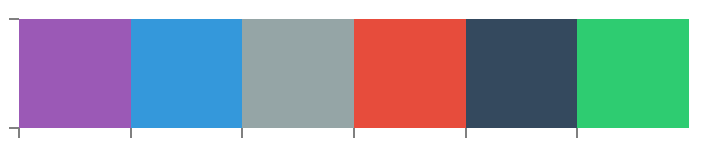

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"
import scipy.misc
from utils import imsave
import tensorflow as tf
import numpy as np
import time
import sys
import matplotlib as mpl

from sar_utilities import to_dB, visualize_raw_data, get_spectrum, \
    visualize_raw_data_spectrum, insert_freq_gaps, \
    generate_raw_data_from_dict, downsample, snr, \
    add_gaussian_noise, preprocess_train, preprocess_test, \
    generate_raw_data
import scipy.io as sio

mpl.rcParams["axes.grid"] = False
mpl.rcParams["grid.color"] = "#f5f5f5"
mpl.rcParams["axes.facecolor"] = "#ededed"
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams['axes.labelcolor'] = "grey"
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams["figure.figsize"] = [4, 3]
from cycler import cycler
import seaborn as sns
color_palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(color_palette)
sns.set_context("paper")
mpl.rcParams["axes.prop_cycle"] = cycler('color', color_palette)
ori_color = color_palette[1]
corrupted_color = color_palette[0]
reconstructed_color = color_palette[5]

DATA_PATH = "/data/dung/sargan"
import os
float_type = np.float32
scene_type = "uniform"
mat_file_name = "deterministic_" + scene_type + "_scene_dict_atom_distance_20"
sar_scene_data = sio.loadmat(os.path.join(DATA_PATH, mat_file_name + ".mat"))
ori_n_apertures = int(sar_scene_data["n_apertures"][0][0])
ori_n_samples = int(sar_scene_data["n_samples"][0][0])
scene_raw_data_mat = np.reshape(sar_scene_data["scene_raw_data"].astype(float_type), 
                                (ori_n_samples, ori_n_apertures), order="F")
scene_image = sar_scene_data["scene_image"].astype(float_type)
transmitted_pulse = sar_scene_data["pulse"].astype(float_type)
transmistted_pulse_sample_period = sar_scene_data["pulse_sampling_period"][0][0].astype(float_type)
sampling_period = transmistted_pulse_sample_period
n_fft = ori_n_samples
sampling_freq = 1. / (sampling_period)
df = sampling_freq / n_fft
freq = [df*i / 1e9 for i in range(0, n_fft)]  
n_samples = ori_n_samples; n_apertures = ori_n_apertures

output_path = os.path.join(DATA_PATH, "radarconf19_figures")

Text(0,0.5,'Sample')

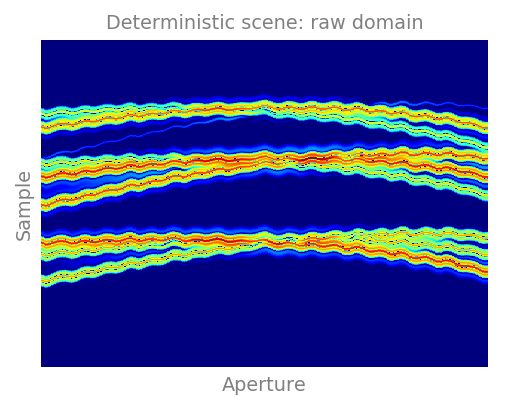

In [104]:
fig = plt.figure(); ax = fig.add_subplot(111)
ax = visualize_raw_data(scene_raw_data_mat, ax, 50)
ax.set_title("Deterministic scene: raw domain", color="gray")
ax.set_xlabel("Aperture"); ax.set_ylabel("Sample")


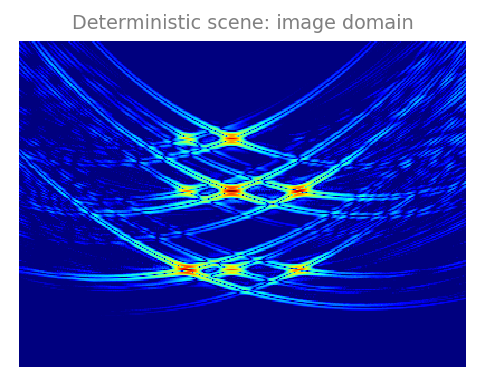

In [106]:
fig = plt.figure(); ax = fig.add_subplot(111)
ax = visualize_raw_data(scene_image[0:250, 50:450], ax, db_range=50)
ax.set_title("Deterministic scene: image domain", color="gray")
uniform_scene_image_filename = os.path.join(output_path, "uniform_scene_image")
# plt.savefig(uniform_scene_image_filename, dpi=300)

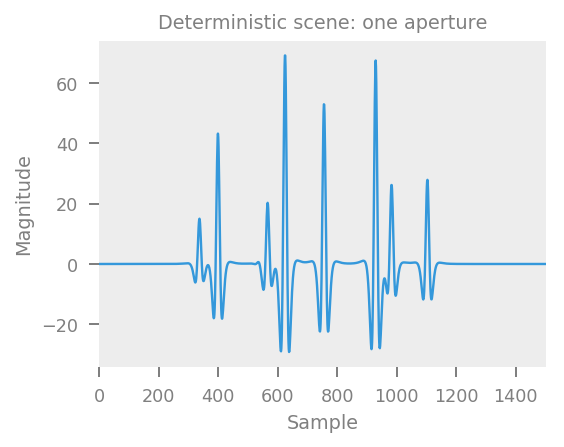

In [107]:
fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(scene_raw_data_mat[:, 0], color=ori_color)
ax.set_title("Deterministic scene: one aperture", color="gray")
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
ax.set_xlim([0, scene_raw_data_mat.shape[0]])
uniform_scene_one_aperture_filename = os.path.join(output_path, "uniform_scene_one_aperture")
# plt.savefig(uniform_scene_one_aperture_filename, dpi=300)

In [ ]:
# # Reshape dictionary to (1200, 300) and rescale to [-0.01, 0.01]
# # sample_range = (150, 1350)
# # aperture_range = (0, 300)
# sample_range = (0, 1500)
# aperture_range = (0, 301)
# n_samples = sample_range[1] - sample_range[0]
# n_apertures = aperture_range[1] - aperture_range[0]
# magnitude_range = (-0.01, 0.01)
# n_atoms = sar_dict_mat.shape[1]

# downsample_factor = 1
# n_samples = n_samples // downsample_factor
# processed_sar_dict = np.empty([n_samples, n_apertures, n_atoms])
# for i_atom in range(sar_dict_mat.shape[1]):
#     atom_mat = np.reshape(sar_dict_mat[:, i_atom], (ori_n_samples, ori_n_apertures), order="F")
#     atom_mat = atom_mat[sample_range[0]:sample_range[1], aperture_range[0]:aperture_range[1]]
#     atom_mat = downsample(atom_mat, downsample_factor, 1)
#     sampling_period *= downsample_factor
#     processed_sar_dict[:, :, i_atom] = atom_mat
    
# # processed_sar_dict *= magnitude_range[1] / np.max(processed_sar_dict)
# reshaped_sar_dict_mat = processed_sar_dict.reshape(n_samples*n_apertures, n_atoms)
# visualize_raw_data(reshaped_sar_dict_mat[:, 0].reshape(n_samples, n_apertures))

In [ ]:
reshaped_sar_dict_mat.shape

In [ ]:
first_atom_mat = reshaped_sar_dict_mat[:, 5].reshape(n_samples, n_apertures)
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
# for i in range(n_apertures):
#     ax.plot(first_atom_mat[:, i])
# ax.plot(first_atom_mat[:, 0], label="0")
# ax.plot(first_atom_mat[:, 150], label="150")
ax.plot(first_atom_mat[:, 209], label="209")
# ax.plot(first_atom_mat[:, 250], label="250")
# ax.plot(first_atom_mat[:, 299], label="300")
ax.plot(1e4*calibrated_real_raw_data[:, 0], label="Real")
ax.legend()

(1500,)


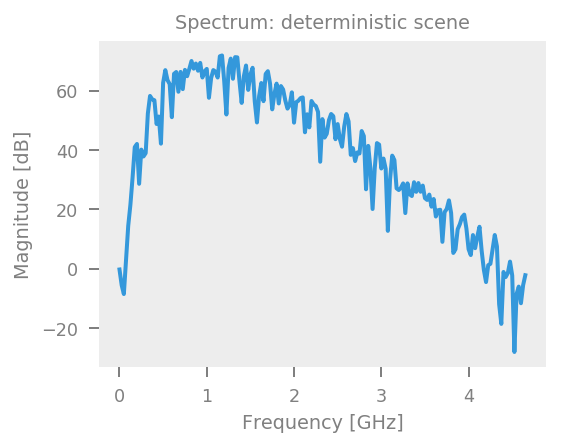

In [92]:
zoom_factor = 8
# fig = plt.figure(figsize=(8, 3)); ax = fig.add_subplot(121);
# raw_spectrum = get_spectrum(transmitted_pulse, n_fft)
# raw_spectrum_dB = to_dB(np.mean(raw_spectrum[0:n_fft//zoom_factor, :], axis=1))
# ax.plot(freq[0:n_fft // zoom_factor], raw_spectrum_dB, color=ori_color, lw=2.0)
# ax.set_title("Spectrum: transmitted pulse", color="gray")
# ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
fig = plt.figure(figsize=(4, 3)); ax = fig.add_subplot(111);
# ax = fig.add_subplot(122);
raw_spectrum = get_spectrum(scene_raw_data_mat[:, 0], n_fft)
raw_spectrum_dB = to_dB(raw_spectrum)
print(raw_spectrum_dB.shape)
ax.plot(freq[0:n_fft // zoom_factor], raw_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=2.0)
ax.set_title("Spectrum: deterministic scene", color="gray")
ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
uniform_scene_spectrum_filename = os.path.join(output_path, "uniform_scene_spectrum")
# plt.savefig(uniform_scene_spectrum_filename, dpi=300)

In [93]:
raw_spectrum_dB

array([-0.31869364, -5.6104565 , -8.596593  , ...,  2.8342361 ,
       -8.596593  , -5.6104565 ], dtype=float32)

In [108]:
sar_scene_data = {}
sar_scene_data["scene_raw_data_mat"] = scene_raw_data_mat
sar_scene_data["scene_image"] = scene_image
sar_scene_data["n_samples"] = n_samples
sar_scene_data["n_apertures"] = n_apertures
sar_scene_data["transmistted_pulse"] = transmitted_pulse
sar_scene_data["transmistted_pulse_sample_period"] = transmistted_pulse_sample_period
sar_scene_data["sampling_period"] = sampling_period

In [110]:
import pickle
saved_filename = mat_file_name
print(saved_filename)
with open(os.path.join(DATA_PATH, saved_filename + ".pickle"), 'wb') as handle:
    pickle.dump(sar_scene_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

deterministic_uniform_scene_dict_atom_distance_20


In [ ]:
os.path.join(DATA_PATH, saved_filename + ".pickle")

In [ ]:
with open(os.path.join(DATA_PATH, saved_filename + ".pickle"), 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
n_nonzero_coefs = 20
vectorized_one_chip = 1e4*calibrated_real_raw_data[:, 0:n_apertures].reshape(n_samples*n_apertures)
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(reshaped_sar_dict_mat, vectorized_one_chip)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(1, 1, 1)
plt.xlim(0, n_atoms)
plt.stem(idx_r, coef[idx_r])

In [ ]:
reshaped_sar_dict_mat.shape
vectorized_one_trip.shape

In [ ]:
real_ori_n_samples, real_ori_n_apertures = real_raw_data.shape
calibrated_real_raw_data = np.vstack((np.zeros((300, real_ori_n_apertures)), real_raw_data, np.zeros((600, real_ori_n_apertures))))

In [ ]:
np.zeros((300, real_ori_n_apertures)).shape